In [2]:
flower_classes = [
'pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english mar,igold'
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',
 'geranium',
 'orange dahlia',
 'pink-yellow dahlia?',
 'cautleya spicata',
 'japanese anemone',
 'black-eyed susan',
 'silverbush',
 'californian poppy',
 'osteospermum',
 'spring crocus',
 'bearded iris',
 'windflower',
 'tree poppy',
 'gazania',
 'azalea',
 'water lily',
 'rose',
 'thorn apple',
 'morning glory',
 'passion flower',
 'lotus',
 'toad lily',
 'anthurium',
 'frangipani',
 'clematis',
 'hibiscus',
 'columbine',
 'desert-rose',
 'tree mallow',
 'magnolia',
 'cyclamen ',
 'watercress',
 'canna lily',
 'hippeastrum ',
 'bee balm',
 'ball moss',
 'foxglove',
 'bougainvillea',
 'camellia',
 'mallow',
 'mexican petunia',
 'bromelia',
 'blanket flower',
 'trumpet creeper',
 'blackberry lily',
]

In [3]:
import numpy as np # linear algebra
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scp
import os
import matplotlib.pyplot as plt
import random
import skimage.io as skio
import skimage.color as skcolor
import glob
import tqdm #progress bar
from PIL import Image
import pickle

/Users/julia.ju/.pyenv/versions/3.9.6/envs/flowers/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


writing the model class

In [4]:
class MyCNN(nn.Module):
    def __init__(self,num_channels=3,num_out_ch=[8,16], img_w =100, img_h=100, num_classes=102):
        super(MyCNN,self).__init__()
        #have 2 simple convolutional layers
        #output of second layer goes into a fully connect layer, which has the end layer (output that has predictions)
        
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(in_features= int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features= num_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0],-1))
        
        return x
    
# model = MyCNN()

# x = torch.randn(32,3,100,100)
# y= model(x)

# print(y.shape)

writing hyperparameters, device, model, optimizer, loss function

In [5]:
#Hyperparameters
NUM_OUT_CH = [8,16]
IMAGE_W = 100
IMAGE_H = 100
BATCH_SIZE = 64
NUM_EPOCHS = 4 
LR = 0.001

#Device
device = "cuda" if torch.cuda.is_available() else "cpu"

#Model
# model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH,img_w=IMAGE_W, img_h= IMAGE_H, num_classes= 102)

# #Optimizer 
# optimizer = optim.Adam(model.parameters(), lr = LR)

# #Loss function
# criterion = nn.CrossEntropyLoss()

In [6]:
data_path = "/Users/julia.ju/Desktop/Flower-Identification-API/model_pipeline/flowers"
label_path = "/Users/julia.ju/Desktop/Flower-Identification-API/model_pipleine/imagelabels.mat"

label_arr = scp.loadmat(label_path)['labels'] #not a a flat array
label_arr -= 1 #soft track all labels so it becomes pythonic

#make a figure
#make a canvas
#put a photo into that
fig, ax = plt.subplots(nrows=2, ncols =4, figsize=(8,6)) #multiple panels in one figure
image_num = random.sample(range(1,8190), 8 )

for i in range(2): #rows
    for j in range(4): #columns
        image = skio.imread(os.path.join(data_path,f"image_{image_num[i*4+j]:05}.jpg"))   
        ax[i,j].imshow(image)
        ax[i,j].axis('off')
        ax[i,j].set_title(f"label: {label_arr[0, image_num[i*4+j]]}")



FileNotFoundError: [Errno 2] No such file or directory: '/Users/julia.ju/Desktop/Flower-Identification-API/imagelabels.mat'

the dimensions for all the flowers are different, so I'm going to go ahead and try scaling them all to the same size.
This might cause issues in feature extraction?

In [ ]:
#dataframe of 8189 indices. Columns are "path" and "label"
labels_ls = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, "*.jpg")))
metadata = pd.DataFrame(
    {'image_path': image_path_list, 'label' :labels_ls}
)

# metadata
type(labels_ls[0])

numpy.uint8

dataset class and loaders

In [ ]:
class FlowerDataset(Dataset):
    #init method
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self,idx):
        image_path = self.metadata.iloc[idx,0]
        image = skio.imread(image_path)
        label = torch.tensor(int(metadata.iloc[idx,1]))
        label = F.one_hot(label, num_classes=102)
        label = label.float()
        if self.transform:
            image = self.transform(image)
        
        return (image,label)
    
flower_transform = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize((IMAGE_W,IMAGE_H)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])

dataset = FlowerDataset(metadata, flower_transform)

#defining dataloaders

train_set, test_set= torch.utils.data.random_split(dataset, [6500,1689])

train_loader = DataLoader(train_set, batch_size= BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size= BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


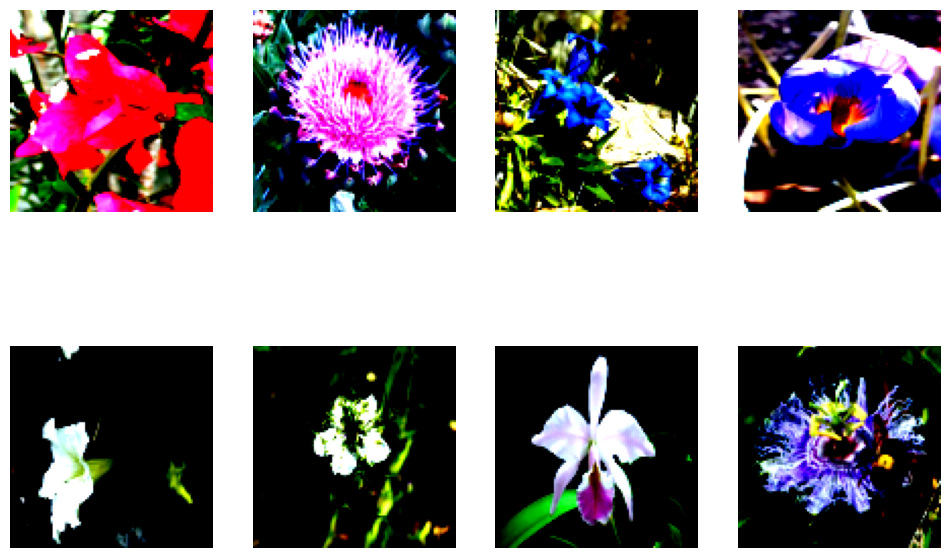

In [ ]:
for x,y in train_loader:
    x = x.to(device) #send x to device
    fix, ax = plt.subplots(nrows=2, ncols=4, figsize = (12,8))
    for i in range(2):
        for j in range(4):
            ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
            ax[i,j].axis('off')
    break
            


all images are now rescaled and normalized which explains their over saturation.
Now we need to write the training loop

In [ ]:

model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH,img_w=IMAGE_W, img_h= IMAGE_H, num_classes= 102)
model = model.to(device)
#Optimizer 
optimizer = optim.Adam(model.parameters(), lr = LR)

#Loss function
criterion = nn.CrossEntropyLoss()
          

Add accuracy function and model evaluation during training

In [ ]:
def check_acc(loader, model):
    num_corrects = 0 
    num_samples = 0
    model.eval()
    
    with torch.no_grad(): #allows us to tell pytorch that its not a training loop
        for x,y in loader:
            
            #send data to device
            x = x.to(device)
            y = y.to(device)
            
            #prepare the data (already done?)
            #forward
            y_hat = model(x)
            
            #calculate the accuracy
            _, labels = y.max(1)
            _, predictions = y_hat.max(1)
            num_corrects += (predictions == labels).sum()
            num_samples += predictions.size(0)
        
    print(f'Accuracy:  {num_corrects}/{num_samples}: {num_corrects/num_samples*100:.2f}')

model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        
        for index, (x,y) in enumerate(train_loader):
            #send data to device
            x = x.to(device)
            y = y.to(device)

            #prepare the data (already done?)
            #forward
            y_hat = model(x)
            loss = criterion(y_hat , y)
            running_loss += loss
            
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())
            
    print(f"Epoch {epoch}: loss: {running_loss}")
    check_acc(loader = test_loader, model=model)

  0%|          | 0/102 [01:49<?, ?batch/s, loss=2.79]


Epoch 0: loss: 357.69964599609375
Accuracy:  473/1689: 28.00


  0%|          | 0/102 [02:00<?, ?batch/s, loss=2.34]


Epoch 1: loss: 190.75927734375
Accuracy:  597/1689: 35.35


  0%|          | 0/102 [01:57<?, ?batch/s, loss=1.01] 


Epoch 2: loss: 84.16059875488281
Accuracy:  652/1689: 38.60


  0%|          | 0/102 [01:53<?, ?batch/s, loss=0.356]


Epoch 3: loss: 30.679880142211914
Accuracy:  605/1689: 35.82


In [ ]:
class PredictDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self,idx):
        image_path = self.metadata.iloc[idx, 0]
        image = Image.open(image_path).convert('RGB')
        sk_image = np.array(image)
        
        if self.transform:
            sk_image = self.transform(sk_image)
        
        return sk_image

def predict(loader, model):

    model.eval()
    
    with torch.no_grad(): #tell pytorch its not a training loop
        for x in loader:
            
            y_hat = model(x)
            _, p_index = y_hat.max(1)
            predicted = p_index.numpy()[0]
            
            predicted_class = flower_classes[predicted]
            print(f"predicted: {predicted_class}")
    

image_path = ['/Users/julia.ju/Desktop/Flower-Identification-API/prediction_image/test_5.jpg']

p_df = pd.DataFrame(
    {'image_path': image_path}
)

p_dataset = PredictDataset(p_df, flower_transform)

loader =torch.utils.data.DataLoader(p_dataset, batch_size=1)

predict(loader, model)

NameError: name 'Dataset' is not defined

save model

In [ ]:
__version__ = '0.1.0'


saved_model = f'./app/model/trained_model-{__version__}.pkl'
file = open(saved_model, "w")
file.close()


with open( saved_model ,'wb') as f:
    pickle.dump(model, f)
    
    # pickle.dump(model, open("model.pkl", "wb"))
